# Determine the Relationship between Age and Terminal Risk

In [1]:
import pyspark
from pyspark.sql import SparkSession, types
from pyspark.sql.functions import col, when
from pyspark.sql.types import StructField, StructType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
import lib.pyspark_helper as helper

In [2]:
spark = SparkSession.builder.master('local[*]').appName('risk').getOrCreate()

## get terminal age percentile

In [3]:
#* read inventory
schema_inventory = StructType([
    StructField('serial_number', types.StringType(), nullable=False),
    StructField('item_type', types.StringType(), nullable=False),
    StructField('status', types.StringType(), nullable=False),
    StructField('date_inserted', types.TimestampType(), nullable=False),
    StructField('bank', types.StringType(), nullable=False)
])

df_inventory = spark.read.csv(path='./bin/inventory_all.csv', schema=schema_inventory, header=True)
df_inventory = df_inventory.withColumn('serial_number', F.substring('serial_number', -15, 15))

df_inventory.printSchema()
df_inventory.show(5)
print('total rows:', df_inventory.count())

root
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- date_inserted: timestamp (nullable = true)
 |-- bank: string (nullable = true)

+---------------+---------------+---------+--------------------+----+
|  serial_number|      item_type|   status|       date_inserted|bank|
+---------------+---------------+---------+--------------------+----+
|15339WL81675637|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|
|15340WL81677713|IWL221-01T2008A|Collected|2017-06-13 11:53:...|absa|
|15340WL81677714|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|
|15340WL81677723|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|
|15340WL81677730|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|
+---------------+---------------+---------+--------------------+----+
only showing top 5 rows

total rows: 394833


In [4]:
df_inventory = df_inventory.withColumn('age', F.datediff(F.lit(F.current_date()), col('date_inserted')))
df_inventory.printSchema()
df_inventory.show(5)

root
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- date_inserted: timestamp (nullable = true)
 |-- bank: string (nullable = true)
 |-- age: integer (nullable = true)

+---------------+---------------+---------+--------------------+----+----+
|  serial_number|      item_type|   status|       date_inserted|bank| age|
+---------------+---------------+---------+--------------------+----+----+
|15339WL81675637|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|1463|
|15340WL81677713|IWL221-01T2008A|Collected|2017-06-13 11:53:...|absa|1463|
|15340WL81677714|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|1463|
|15340WL81677723|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|1463|
|15340WL81677730|IWL221-01T1515A|Activated|2017-06-13 11:53:...|absa|1463|
+---------------+---------------+---------+--------------------+----+----+
only showing top 5 rows



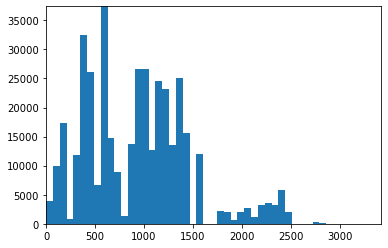

In [5]:
helper.plot_histogram(df_inventory, 'age', binStep=50)

In [6]:
window_spec = Window.orderBy('age')

df_inventory = df_inventory.withColumn(
    'age_percentile', 
    F.percent_rank().over(window_spec) * 100
)

df_inventory = df_inventory.withColumn(
    'risk', 
    helper.get_risk_interval('age_percentile')
)

df_inventory.printSchema()

root
 |-- serial_number: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- date_inserted: timestamp (nullable = true)
 |-- bank: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- age_percentile: double (nullable = true)
 |-- risk: string (nullable = true)



+-----------+-------+-------+-----+
|       risk|age_min|age_max|range|
+-----------+-------+-------+-----+
| 1_very_low|     25|    455|  430|
|      2_low|    468|    679|  211|
|   3_medium|    684|   1029|  345|
|     4_high|   1034|   1327|  293|
|5_very_high|   1335|   3490| 2155|
+-----------+-------+-------+-----+



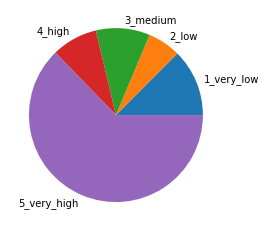

In [7]:
#* date range for each risk interval
df_risk_range = df_inventory.groupBy('risk')\
    .agg(
        F.min(df_inventory.age).alias('age_min'), 
        F.max(df_inventory.age).alias('age_max')
    ).withColumn('range', col('age_max') - col('age_min'))

df_risk_range.show()
helper.plot_pie(df_risk_range, 'range', 'risk')

+-------+------+
|   bank| count|
+-------+------+
|   absa|106260|
|    fnb|220912|
|   sbsa| 55083|
|dashpay| 12578|
+-------+------+



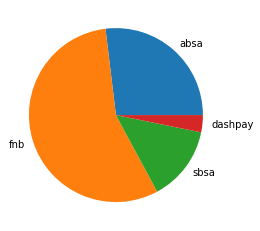

In [8]:
#* number of terminals for each bank
df_inventory_count = df_inventory.groupBy('bank').count()

df_inventory_count.show()
helper.plot_pie(df_inventory_count, 'count', 'bank')

## terminal age vs written-off

### all banks

+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|82208|
|      2_low|78076|
|   3_medium|78204|
|     4_high|84002|
|5_very_high|72343|
+-----------+-----+



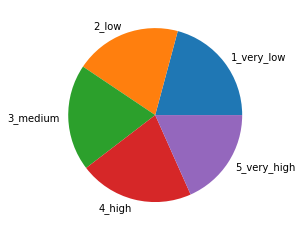

In [9]:
#* risk distribution of devices from all banks
df_risk_all = df_inventory.groupBy('risk').count()
df_risk_all.show()
helper.plot_pie(df_risk_all, 'count', 'risk')

+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|  185|
|      2_low|  598|
|   3_medium| 2845|
|     4_high| 5261|
|5_very_high| 7909|
+-----------+-----+



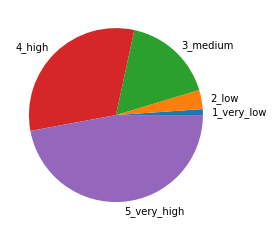

In [10]:
#* written off terminal grouped by risk
df_writtenoff_1 =  df_inventory.filter(
    (col('status') == 'Written Off') | 
    (col('status') == 'Awaiting Write-Off')
).groupBy('risk').count()

df_writtenoff_1.show()
helper.plot_pie(df_writtenoff_1, 'count', 'risk')

+-------+-----+
|   bank|count|
+-------+-----+
|   absa| 4204|
|    fnb| 3406|
|   sbsa| 7837|
|dashpay| 1351|
+-------+-----+



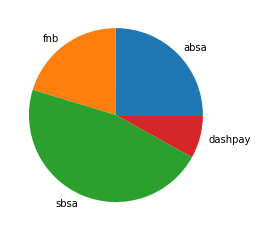

In [11]:
#* written off terminal grouped by bank
df_writtenoff_2 = df_inventory.filter(
    (col('status') == 'Written Off') | 
    (col('status') == 'Awaiting Write-Off')
).groupBy('bank').count()

df_writtenoff_2.show()
helper.plot_pie(df_writtenoff_2, 'count', 'bank')

+-------+-----+
|   bank|count|
+-------+-----+
|   absa|10578|
|    fnb|32004|
|dashpay| 1595|
|   sbsa|28166|
+-------+-----+



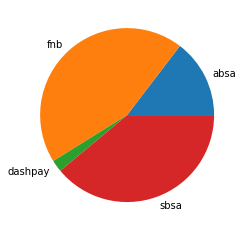

In [12]:
#* very high risk devices grouped by bank
df_writtenoff_3 = df_inventory.filter(
    (col('risk') == '5_very_high')
).groupBy('bank').count()

df_writtenoff_3.show()
helper.plot_pie(df_writtenoff_3, 'count', 'bank')

### dashpay

+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low| 1806|
|      2_low| 4067|
|   3_medium| 4110|
|     4_high| 1000|
|5_very_high| 1595|
+-----------+-----+



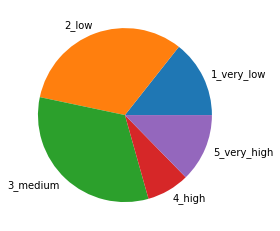

In [13]:
#* dashpay overall distribution
df_dashpay = df_inventory.filter((col('bank') == 'dashpay')).groupBy('risk').count()
df_dashpay.show()
helper.plot_pie(df_dashpay, 'count', 'risk')

total: 1351
+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|   29|
|      2_low|  153|
|   3_medium|  387|
|     4_high|  137|
|5_very_high|  645|
+-----------+-----+



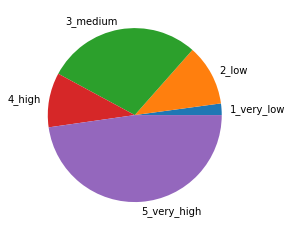

In [14]:
#* dashpay written-off distribution
df_dashpay_wo =  df_inventory.filter(
        (col('bank') == 'dashpay') & 
        (
            (col('status') == 'Written Off') | 
            (col('status') == 'Awaiting Write-Off')
        )
    ).groupBy('risk').count()

print('total:', helper.get_col_sum(df_dashpay_wo, 'count'))
df_dashpay_wo.show()
helper.plot_pie(df_dashpay_wo, 'count', 'risk')

### fnb

+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|49408|
|      2_low|63000|
|   3_medium|54300|
|     4_high|22200|
|5_very_high|32004|
+-----------+-----+



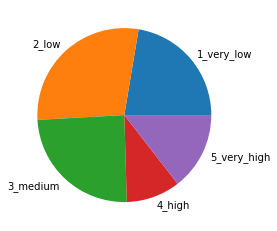

In [15]:
#* fnb overall distribution
df_fnb = df_inventory.filter((col('bank') == 'fnb')).groupBy('risk').count()
df_fnb.show()
helper.plot_pie(df_fnb, 'count', 'risk')

total: 3406
+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|   53|
|      2_low|  348|
|   3_medium|  822|
|     4_high|  640|
|5_very_high| 1543|
+-----------+-----+



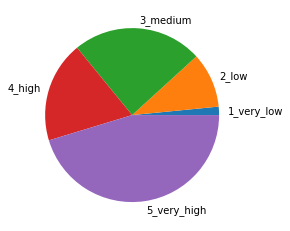

In [16]:
#* fnb written-off distribution
df_fnb_wo =  df_inventory.filter(
        (col('bank') == 'fnb') & 
        (
            (col('status') == 'Written Off') | 
            (col('status') == 'Awaiting Write-Off')
        )
    ).groupBy('risk').count()

print('total:', helper.get_col_sum(df_fnb_wo, 'count'))
df_fnb_wo.show()
helper.plot_pie(df_fnb_wo, 'count', 'risk')

### absa

+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|23001|
|      2_low|11000|
|   3_medium| 5080|
|     4_high|56601|
|5_very_high|10578|
+-----------+-----+



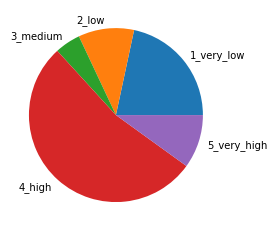

In [17]:
#* absa overall distribution
df_absa = df_inventory.filter((col('bank') == 'absa')).groupBy('risk').count()
df_absa.show()
helper.plot_pie(df_absa, 'count', 'risk')

total: 4204
+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|   53|
|      2_low|   97|
|   3_medium|  134|
|     4_high| 3474|
|5_very_high|  446|
+-----------+-----+



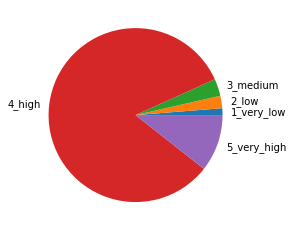

In [18]:
#* absa written-off distribution
df_absa_wo =  df_inventory.filter(
        (col('bank') == 'absa') & 
        (
            (col('status') == 'Written Off') | 
            (col('status') == 'Awaiting Write-Off')
        )
    ).groupBy('risk').count()

print('total:', helper.get_col_sum(df_absa_wo, 'count'))
df_absa_wo.show()
helper.plot_pie(df_absa_wo, 'count', 'risk')

### standard bank

+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low| 7993|
|      2_low|    9|
|   3_medium|14714|
|     4_high| 4201|
|5_very_high|28166|
+-----------+-----+



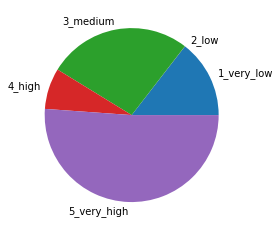

In [19]:
#* sbsa overall distribution
df_sbsa = df_inventory.filter((col('bank') == 'sbsa')).groupBy('risk').count()
df_sbsa.show()
helper.plot_pie(df_sbsa, 'count', 'risk')

total: 7837
+-----------+-----+
|       risk|count|
+-----------+-----+
| 1_very_low|   50|
|   3_medium| 1502|
|     4_high| 1010|
|5_very_high| 5275|
+-----------+-----+



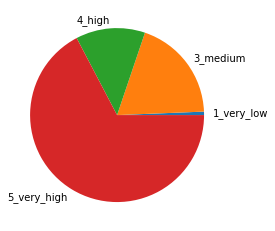

In [20]:
#* sbsa written-off distribution
df_sbsa_wo =  df_inventory.filter(
        (col('bank') == 'sbsa') & 
        (
            (col('status') == 'Written Off') | 
            (col('status') == 'Awaiting Write-Off')
        )
    ).groupBy('risk').count()

print('total:', helper.get_col_sum(df_sbsa_wo, 'count'))
df_sbsa_wo.show()
helper.plot_pie(df_sbsa_wo, 'count', 'risk')

___
### reminder: to save dataframe to csv

`df_inventory.toPandas().to_csv(<out-path>, index=False)`
